## Step 1: Importing the Libraries

Before diving into the data, let’s load the libraries we’ll use throughout the notebook.  
These include tools for handling data, visualization, and building our regression model.

In [ ]:
# Basic packages
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Step 2: Loading the Train and Test Data

We’re using the dataset from `Kaggle's House Prices` competition.  
Let’s first load both the training and test sets to begin exploring and cleaning them.


In [ ]:
# Upload train.csv and test.csv manually in Colab
train = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
# Basic info
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Step 3: Cleaning and Preprocessing the Data

Some columns have too many missing values or aren't useful, so we drop them.  
We then handle the missing values and apply one-hot encoding to convert categorical variables into numerical format.


In [ ]:
# Store the ID column for submission later
test_ids = test['Id']

# Drop high-missing or non-useful columns
drop_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [ ]:
# Combine for joint preprocessing
train['source'] = 'train'
test['source'] = 'test'
full_data = pd.concat([train, test], axis=0)

In [ ]:
# Fill missing values
full_data['LotFrontage'] = full_data['LotFrontage'].fillna(full_data['LotFrontage'].mean())
full_data.fillna(full_data.mode().iloc[0], inplace=True)

In [ ]:
# One-hot encode categorical variables
full_data = pd.get_dummies(full_data, drop_first=True)

In [ ]:
# Separate back into train/test
train_data = full_data[full_data['source_train'] == 1].drop(columns=['source_train'])
test_data = full_data[full_data['source_train'] == 0].drop(columns=['source_train', 'SalePrice'])

## Step 4: Exploring the Data

Before jumping into modeling, it helps to visualize the relationships in our data.  
We’ll look at how features like living area correlate with house price and check for any strong linear relationships we can use.


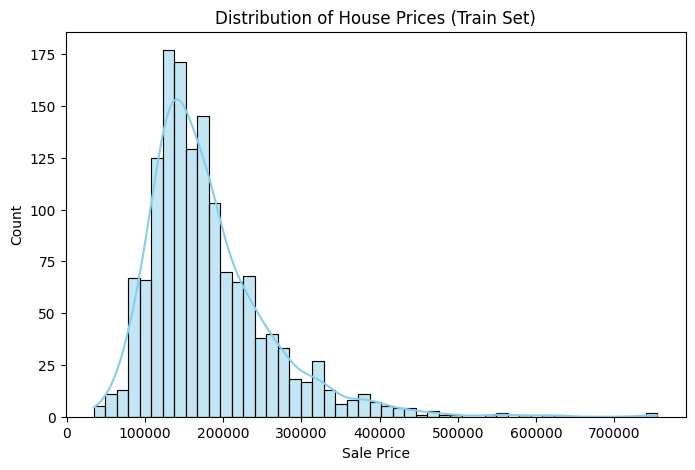

In [ ]:
# Target Variable Distribution
plt.figure(figsize=(8, 5))
sns.histplot(train['SalePrice'], kde=True, color='skyblue')
plt.title('Distribution of House Prices (Train Set)')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.show()



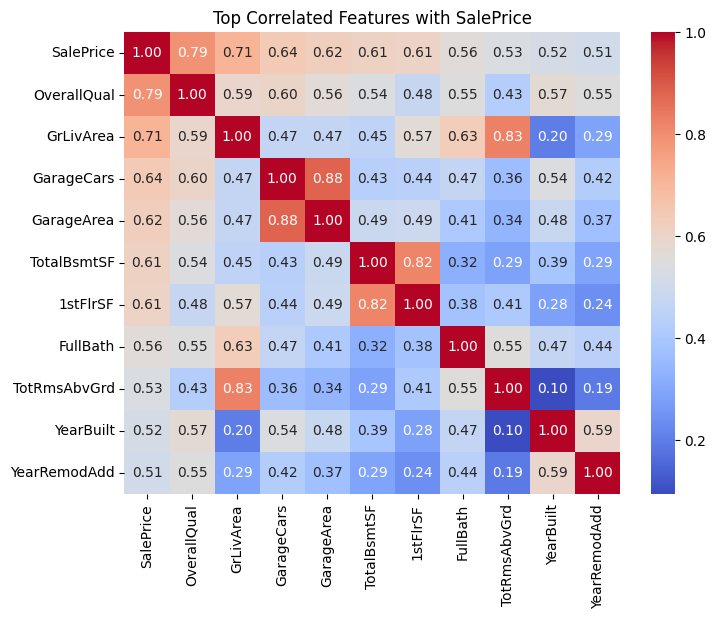

In [ ]:
# Correlation with SalePrice (HeatMap)
# Using only numeric columns for correlation
numeric_train = train.select_dtypes(include=[np.number])

# Get top correlated features with SalePrice
top_corr = numeric_train.corr()['SalePrice'].abs().sort_values(ascending=False).head(11)

# Plot heatmap of those top features
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_train[top_corr.index].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Features with SalePrice")
plt.show()




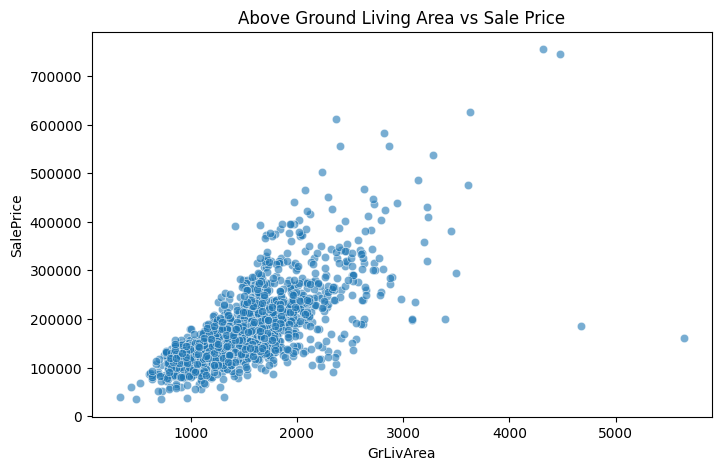

In [ ]:
# GrLivArea vs SalePrice (Scatter Plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice', alpha=0.6)
plt.title('Above Ground Living Area vs Sale Price')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()


/tmp/ipython-input-13-369502794.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OverallQual', y='SalePrice', data=train, palette='Blues')


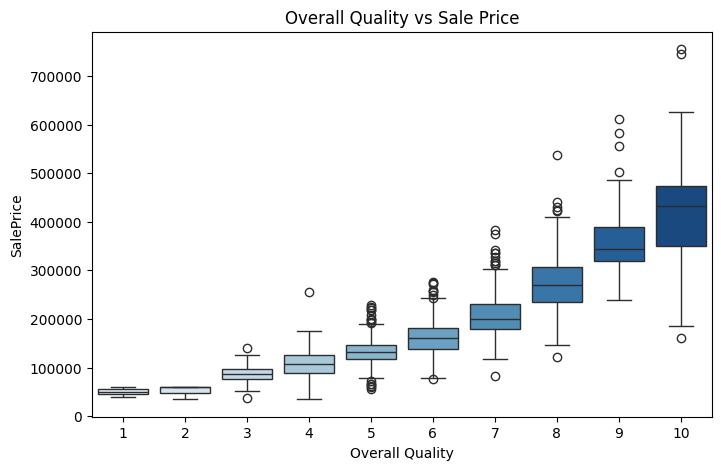

In [ ]:
# OverallQual vs SalePrice (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train, palette='Blues')
plt.title('Overall Quality vs Sale Price')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')
plt.show()


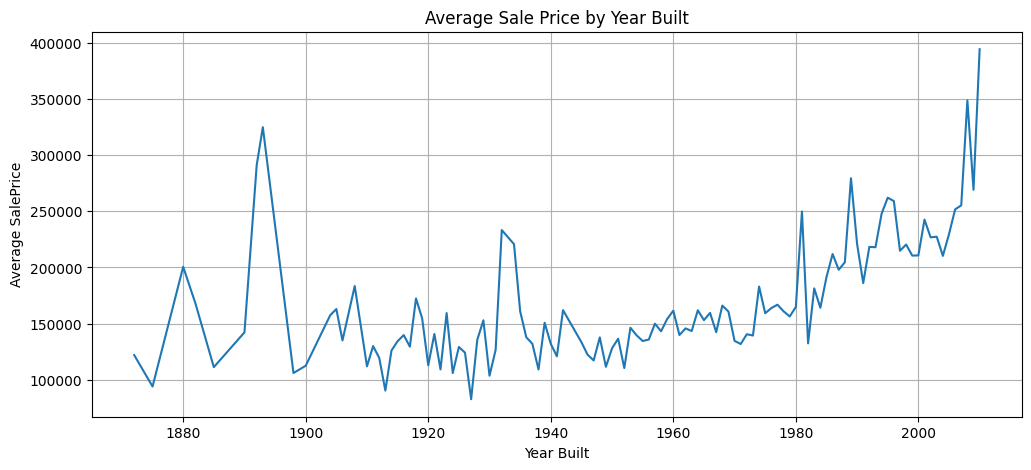

In [ ]:
# Grouped mean prices by year
year_price = train.groupby('YearBuilt')['SalePrice'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=year_price, x='YearBuilt', y='SalePrice')
plt.title('Average Sale Price by Year Built')
plt.ylabel('Average SalePrice')
plt.xlabel('Year Built')
plt.grid(True)
plt.show()


/tmp/ipython-input-39-1493374615.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-39-1493374615.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


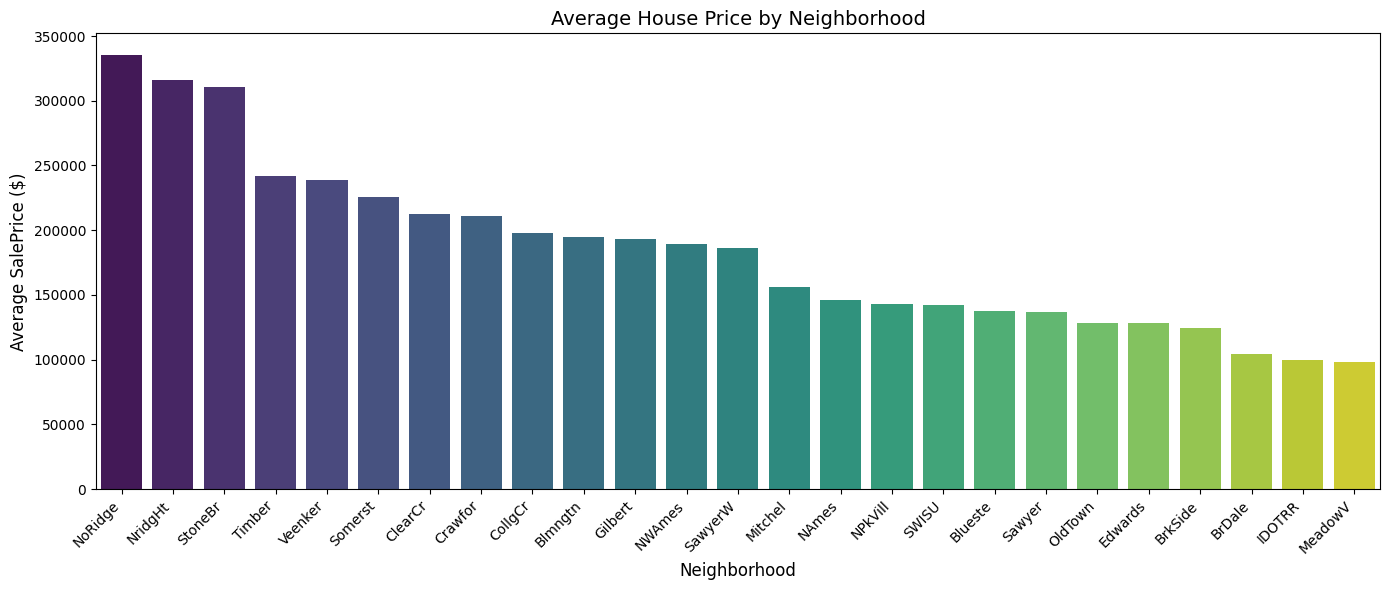

In [ ]:
# Mean SalePrice by neighborhood
# Sort neighborhoods by average SalePrice
neighborhood_order = train.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index

plt.figure(figsize=(14, 6))
sns.barplot(
    data=train,
    x='Neighborhood',
    y='SalePrice',
    order=neighborhood_order,
    palette='viridis',
    ci=None
)

plt.xticks(rotation=45, ha='right')
plt.title('Average House Price by Neighborhood', fontsize=14)
plt.ylabel('Average SalePrice ($)', fontsize=12)
plt.xlabel('Neighborhood', fontsize=12)
plt.tight_layout()
plt.show()


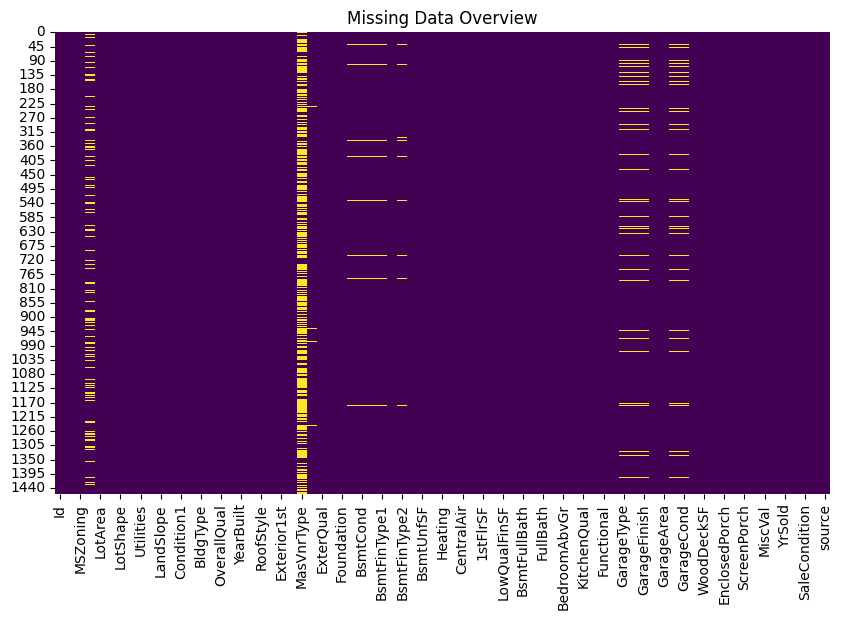

In [ ]:
# Heatmap of Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Overview")
plt.show()


## Step 5: Training the Linear Regression Model

We now train a `simple linear regression model` using all available training data.


In [ ]:
# Define features (drop ID and target)
X_train = train_data.drop(columns=['Id', 'SalePrice'])
y_train = train_data['SalePrice']

In [ ]:
# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Step 6: Predicting on the Test Set

Once the model is trained, we use it to predict house prices on the test set.  


In [ ]:
# Predict on test set
predictions = model.predict(test_data.drop(columns=['Id']))

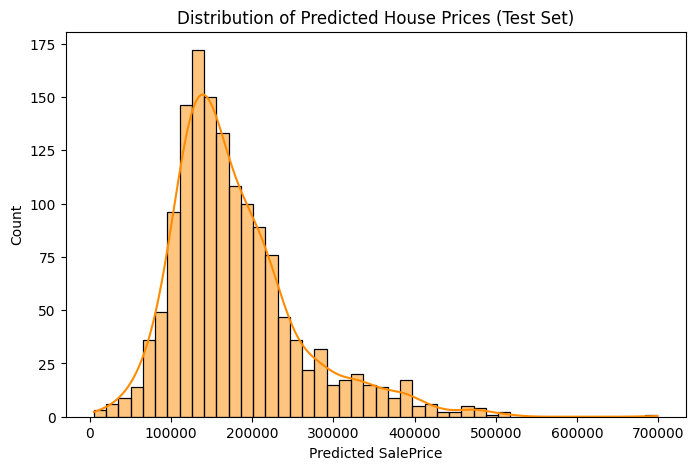

In [ ]:
# Plot Distribution of Predicted Prices
plt.figure(figsize=(8, 5))
sns.histplot(predictions, kde=True, color='darkorange')
plt.title("Distribution of Predicted House Prices (Test Set)")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-33-3104907289.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, label='Train SalePrice', shade=True)
/tmp/ipython-input-33-3104907289.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions, label='Test Predictions', shade=True)


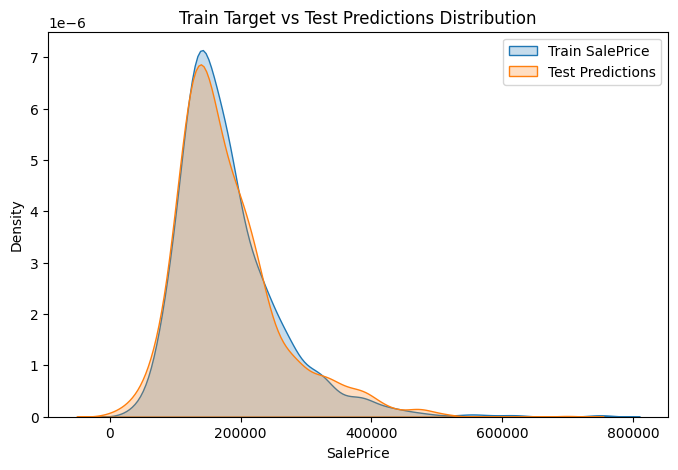

In [ ]:
# Compare Train vs. Test Predictions Distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train, label='Train SalePrice', shade=True)
sns.kdeplot(predictions, label='Test Predictions', shade=True)
plt.title("Train Target vs Test Predictions Distribution")
plt.xlabel("SalePrice")
plt.legend()
plt.show()


## Step 7: Evaluating the Model

After training, we evaluate how well the model performs on the test set using common regression metrics like `MAE, MSE, RMSE, and R² Score`.


In [ ]:
# Predict on the training data
train_preds = model.predict(X_train)

# Evaluation metrics
mae = mean_absolute_error(y_train, train_preds)
mse = mean_squared_error(y_train, train_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, train_preds)

# Display results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



Mean Absolute Error (MAE): 13460.24
Mean Squared Error (MSE): 439169238.95
Root Mean Squared Error (RMSE): 20956.37
R² Score: 0.9304


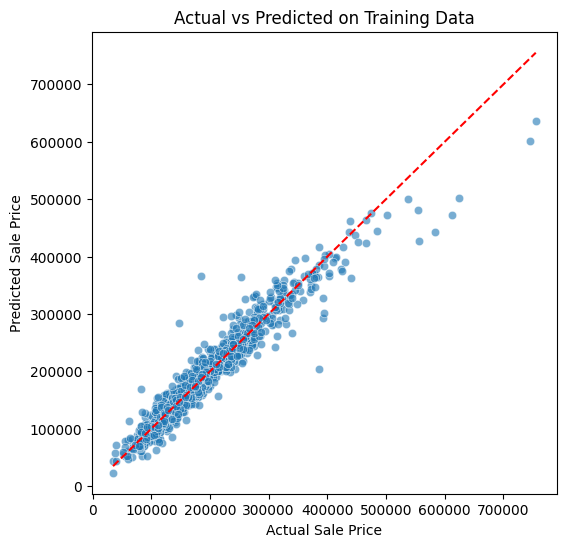

In [ ]:
# Actual vs Predicted Plot (Visual Check)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_train, y=train_preds, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted on Training Data')
plt.show()


## 📈 Model Evaluation Results

After training our linear regression model, we evaluated it on the training data using several standard regression metrics:

- **`Mean Absolute Error (MAE)`**: `$13,460 `
- **`Mean Squared Error (MSE)`**: `$439,169,239`  
- **`Root Mean Squared Error (RMSE)`**: `$20,956`  
- **`R² Score`**:` 0.9304`

These results suggest that the model explains around `93%` of the variation in house prices, with an average prediction error of `$13K to $21K`. This level of accuracy is quite strong for a basic linear model trained on limited features.


## Step 7: Saving the Model

If we want to reuse this model later, we can save it to a file using `joblib` and load it back when needed.


In [ ]:
import joblib
joblib.dump(model, 'linear_regression_model.pkl')


['linear_regression_model.pkl']